In [1]:
from __future__ import print_function
import struct
import numpy as np
import matplotlib.pyplot as plt
import math
import tensorflow as tf
from tensorflow.python.framework import ops


def read_idx(filename):
    with open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.fromstring(f.read(), dtype=np.uint8).reshape(shape)


trainImages = read_idx('train-images-idx3-ubyte')
trainLabels = read_idx('train-labels-idx1-ubyte')
testImages = read_idx('t10k-images-idx3-ubyte')
testLabels = read_idx('t10k-labels-idx1-ubyte')

train_data = trainImages.reshape(trainImages.shape[0],-1)
test_data = testImages.reshape(testImages.shape[0],-1)
train_label = trainLabels.reshape(trainImages.shape[0],1)
test_label = testLabels.reshape(testImages.shape[0],1)

print('trainImages size:' + str(train_data.shape))
print('trainLabels size:' + str(train_label.shape))
print('testImages size:' + str(test_data.shape))
print('testLabels size:' + str(test_label.shape))

//anaconda3/envs/tensorflow/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)


trainImages size:(60000, 784)
trainLabels size:(60000, 1)
testImages size:(10000, 784)
testLabels size:(10000, 1)


//anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:14: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  


In [2]:
#One Hot Encoding
def one_hot_matrix(Y_onehot,C):
    Y_onehot = np.eye(C)[Y_onehot.reshape(-1)].T
    return Y_onehot

train_data = train_data.T
train_label = train_label.T
test_data = test_data.T
test_label = test_label.T

print('train_data size:' + str(train_data.shape))
print('train_label size:' + str(train_label.shape))
print('test_data size:' + str(test_data.shape))
print('test_label size:' + str(test_label.shape))

train_data size:(784, 60000)
train_label size:(1, 60000)
test_data size:(784, 10000)
test_label size:(1, 10000)


In [3]:
train_label_one_hot = one_hot_matrix(train_label,10)
test_label_one_hot = one_hot_matrix(test_label,10)

print('train_label size:' + str(train_label_one_hot.shape))
print('test_label size:' + str(test_label_one_hot.shape))

train_label size:(10, 60000)
test_label size:(10, 10000)


In [4]:
#Creating Placeholders
def create_placeholder(n_x,n_y):
    X = tf.placeholder(tf.float32, [n_x, None], name="X")
    Y = tf.placeholder(tf.float32, [n_y, None], name="Y")
    
    return X,Y

In [5]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    #number of training examples
    m = X.shape[1]
    mini_batches = []
    np.random.seed(seed)
    
    #Step 1: Shuffle(X,Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((Y.shape[0],m))
    
    #Step 2: Partition (shuffled_X, shuffled_Y). (Not including the end case)
    #number of mini batches of size mini_batch_size in your partitionning
    num_complete_minibatches = math.floor(m/mini_batch_size)
    for i in range(0,num_complete_minibatches):
        mini_batch_X = shuffled_X[:, i*mini_batch_size : i*mini_batch_size + mini_batch_size]
        mini_batch_Y = shuffled_Y[:, i*mini_batch_size : i*mini_batch_size + mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    #Step 3: Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [6]:
#Initializing Parameters
def initialize_parameters(n_size):
    tf.set_random_seed(1)
    
    W1 = tf.get_variable("W1",shape=[n_size,784],initializer = tf.contrib.layers.xavier_initializer(seed=1))
    b1 = tf.get_variable("b1", [n_size, 1], initializer = tf.zeros_initializer())
    W2 = tf.get_variable("W2", [n_size, n_size], initializer = tf.contrib.layers.xavier_initializer(seed=1))
    b2 = tf.get_variable("b2", [n_size, 1], initializer = tf.zeros_initializer())
    W3 = tf.get_variable("W3", [10, n_size], initializer = tf.contrib.layers.xavier_initializer(seed=1))
    b3 = tf.get_variable("b3", [10, 1], initializer = tf.zeros_initializer())
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters

In [7]:
#Forward Propagation
def forward_propagation(X,parameters):
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    Z1 = tf.add(tf.matmul(W1, X), b1)
    A1 = tf.nn.relu(Z1)
    Z2 = tf.add(tf.matmul(W2, A1), b2)
    A2 = tf.nn.relu(Z2)
    Z3 = tf.add(tf.matmul(W3, A2), b3)

    
    return Z3

In [8]:
#Compute Cost
def compute_cost(Z3,Y):
    logits = tf.transpose(Z3)
    labels = tf.transpose(Y)
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits,labels=labels))
    
    return cost

In [9]:
#Backward Propagation and Parameter Updates
def model(X_train, Y_train, X_test, Y_test, n_size, learning_rate = 0.001,
          num_epochs = 20, minibatch_size = 64, print_cost = True):
    #Neural Network with 2 Hidden Layers: Linear->Relu->Linear->Relu->Linear->Softmax
    
    #Rerun model without overwriting tf variables
    ops.reset_default_graph()
    tf.set_random_seed(1)
    seed = 3 
    (n_x, m) = train_data.shape
    n_y = train_label_one_hot.shape[0]
    costs = []
    
    X,Y = create_placeholder(n_x,n_y)
    parameters = initialize_parameters(n_size)
    
    #Forward propagation: Build the forward propagation
    Z3 = forward_propagation(X,parameters)
    
    #Cost function: Add cost function to tensorflow graph
    cost = compute_cost(Z3, Y)
    
    #Backpropagation: Descent of Gradient Usine AdamOptimizer
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    
    # Initialize all the variables
    init = tf.global_variables_initializer()
    
    with tf.Session() as sess:
        
        #Session to compute tensorflow graph
        sess.run(init)
        
        #Training Loop
        for epoch in range(num_epochs):

            #Define a cost related to an epoch
            epoch_cost = 0 
            #Number of minibatches of size minibatch_size in the train set
            num_minibatches = int(m / minibatch_size) 
            seed = seed + 1
            minibatches = random_mini_batches(train_data, train_label_one_hot, minibatch_size, seed)

            for minibatch in minibatches:

                (minibatch_X, minibatch_Y) = minibatch
                
                #The line that runs the graph on a minibatch.
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                
                #Total epoch cost for all minibatches combined
                epoch_cost += minibatch_cost / num_minibatches 

            # Print the cost every epoch
            if print_cost == True:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))

                
        parameters = sess.run(parameters)
        print("Parameters have been trained!")

        #Calculate the correct predictions
        #Returns the index with the largest value 
        correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y)) 

        #Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, dtype="float"))
        print("Number of Hidden Neurons = %d, Train Accuracy = %f%%"
              %(n_size,accuracy.eval({X: X_train, Y: Y_train})*100))
        print("Number of Hidden Neurons = %d, Test Accuracy = %f%%"
              %(n_size,accuracy.eval({X: X_test, Y: Y_test})*100))
        test_accuracy = (accuracy.eval({X: X_test, Y: Y_test}))*100
        
        return parameters,test_accuracy

In [10]:
accuracy_result = []
neurons = [4,8,16,32,64,128,256]
for i in range(len(neurons)):
    parameters_result,accuracy_new = model(train_data,train_label_one_hot,test_data,test_label_one_hot,neurons[i])
    accuracy_result.append(accuracy_new)
    

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

Cost after epoch 0: 2.614573
Cost after epoch 1: 2.303800
Cost after epoch 2: 2.303638
Cost after epoch 3: 2.303178
Cost after epoch 4: 2.301787
Cost after epoch 5: 2.283360
Cost after epoch 6: 2.257548
Cost after epoch 7: 2.145265
Cost after epoch 8: 1.945207
Cost after epoch 9: 1.826064
Cost after epoch 10: 1.789366
Cost after epoch 11: 1.765872
Cost after epoch 12: 1.738043
Cost after epoch 13: 1.712213
Cost after epoch 14: 1.691085
Cost after epoch 15: 1.675184
Cost after epoch 16: 1.655246
Cost after epoch 17: 1.640604
Cost after epoch 18: 1.624675
Cost after epoch 19: 1.606121
Parameters have been trained!
Number of Hidden Neurons = 4, Train Accuracy = 38.205001%
Number of Hidden Neurons = 4, Test Accuracy = 38.550001%
Cost after epoch 0: 2.339911
Cost after epoch 1: 1.762666
Cost after epoc

Text(0.5, 1.0, 'Accuracy vs. Number of Neurons')

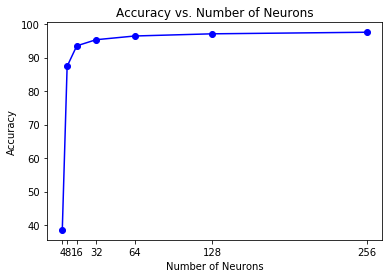

In [11]:
accuracy_result = np.round(accuracy_result,2)
plt.plot(neurons,accuracy_result,'ob-')
plt.ylabel('Accuracy')
plt.xlabel('Number of Neurons')
plt.xticks([4,8,16,32,64,128,256])
plt.title('Accuracy vs. Number of Neurons')